In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
# csv files for answer responses
gdrive_path = "/Users/dorislee/Google Drive/Turn/VAST/user_study/evaluation_study/transcription_and_analysis/"
# user study logs
box_path = "/Users/dorislee/Box/viz-summarization-user-study-material/" 

In [4]:
user_task =  pd.read_csv(gdrive_path+"UserTaskAssignment.csv")

# Ranking

In [5]:
def dcg(r, k, method=0):
    # alternative formulation of DCG places stronger emphasis on retrieving relevant documents
    r = np.asfarray(r)[:k]
    val = 0
    for i in range(1,len(r)):
        val+= (2**r[i]-1) / np.log2(i+1)
    return val

def ndcg(dcg_ground_truth,r, k):
    return dcg(r, k) / sum(dcg_ground_truth)


In [6]:
def compute_ndcg_rankings(user_ranking_filename,gt_ranking_filename):
    user_rank = pd.read_csv(gdrive_path+user_ranking_filename)
    ground_truth_rank = pd.read_csv(gt_ranking_filename,index_col=0)
    ground_truth_cramerV_rank = list(ground_truth_rank["cramerV"].rank(ascending=False)) 
    #highest cramer's V corresponds to most correlated, corresponds to rank 1
    user_rank = user_rank.merge(user_task).drop("Note",axis=1)
    user_rankings=[]
    #Putting user rankings into appropriate data structures
    for row in user_rank.iterrows():
        ranking = []
        for attr in ground_truth_rank.attribute:
            ranking.append(row[1][attr])
        task = row[1]["Task1"]
        user_rankings.append([task,ranking])
    #Computing ndcg ranking
    ndcg_data = []
    for trial in user_rankings:
        ndcg_d = []
        ndcg_d.append(trial[0])
        for k in [1,2,3,5,7]:
            ndcg_d.append(ndcg(ground_truth_cramerV_rank,trial[1],k))
        ndcg_data.append(ndcg_d)
    ndcg_result = pd.DataFrame(ndcg_data,columns=["Task","NDCG@1","NDCG@2","NDCG@3","NDCG@5","NDCG@7"])
    return ndcg_result.groupby("Task",as_index=False).mean()

In [7]:
compute_ndcg_rankings("Ranking(Police).csv","ct_police_ground_truth_correlation.csv")

,Task,NDCG@1,NDCG@2,NDCG@3,NDCG@5,NDCG@7
0,A1,0,0.351190,0.441323,0.511916,0.628532
1,A2,0,0.196429,0.249006,0.382285,0.453713
2,A3,0,0.121429,0.161988,0.412936,0.842741


In [8]:
compute_ndcg_rankings("Ranking(Autism).csv","autism_ground_truth_correlation.csv")

,Task,NDCG@1,NDCG@2,NDCG@3,NDCG@5,NDCG@7
0,A1,0,0.133333,0.173483,1.525712,2.128862
1,A2,0,0.109091,0.258220,0.283347,0.452386
2,A3,0,0.021818,0.035584,0.055332,0.106782


This makes sense, our algo does better than kmeans (2) and level-wise BFS (3), except for NDCG@3 A2 for some reason did very well.

# Prediction

In [9]:
prediction_ground_truth = {
    'Police1': [55.1,4.2,40.7], #ticket,warn,arrest
    'Police2': [53.43,12.02,34.55], #ticket,warn,arrest
    'Autism1': [17.3,82.7], #NO,YES   
    'Autism2': [41,59] #NO,YES   
}

In [10]:
def euclidean_dist(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.sqrt(np.sum(((x-y)**2)))

In [11]:
def compute_prediction_distances(filename,gt_task_key):
    prediction = pd.read_csv(gdrive_path+filename)
    if "Police" in filename: 
        attributes = ["ticket","warn","arrest"]
        task_name = "Task1"
    else: 
        attributes = ["NO","YES"]
        task_name = "Task2"
    prediction = prediction.merge(user_task).drop("Note",axis=1)
    
    #Computing Euclidean Distance
    dist_data = []
    for row in prediction.iterrows():
        user_prediction  = row[1][attributes].values
        gt_prediction = prediction_ground_truth[gt_task_key]
        dist_data.append([row[1][task_name],euclidean_dist(user_prediction,gt_prediction)])
    dist_result = pd.DataFrame(dist_data,columns=["Task","Distance"])
    dist_result.groupby("Task",as_index=False)
    #mean and standard deviation
    distance_aggregate_result = dist_result.groupby("Task",as_index=False)["Distance"].mean()
    distance_aggregate_result["SD"] = dist_result.groupby("Task",as_index=False)["Distance"].apply(lambda x: x.std())
    return distance_aggregate_result

In [12]:
compute_prediction_distances("Prediction1(Police).csv","Police1")

,Task,Distance,SD
0,A1,9.687562,6.465089
1,A2,37.566882,16.323091
2,A3,52.202478,28.153713


In [13]:
compute_prediction_distances("Prediction2(Police).csv","Police2")

,Task,Distance,SD
0,A1,10.138272,4.116052
1,A2,11.607803,4.966252
2,A3,30.708144,36.935642


In [14]:
compute_prediction_distances("Prediction1(Autism).csv","Autism1")

,Task,Distance,SD
0,B1,8.438141,8.628634
1,B2,14.905811,25.426286
2,B3,48.813938,5.960145


In [15]:
compute_prediction_distances("Prediction2(Autism).csv","Autism2")

,Task,Distance,SD
0,B1,26.280802,15.036068
1,B2,19.233304,14.057027
2,B3,16.499158,9.784341


In [108]:
%load_ext autoreload
%autoreload 2
from paper_visualization import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


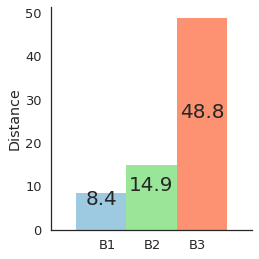

In [29]:
result = compute_prediction_distances("Prediction1(Autism).csv","Autism1")
bar_chart(list(result["Distance"].values),list(result["Task"].values), ytitle="Distance",fixed_ylim=False)

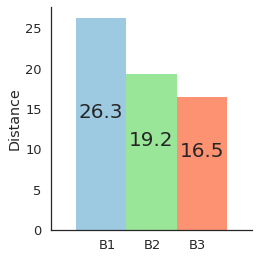

In [19]:
result = compute_prediction_distances("Prediction2(Autism).csv","Autism2")
bar_chart(list(result["Distance"].values),list(result["Task"].values), ytitle="Distance",fixed_ylim=False)

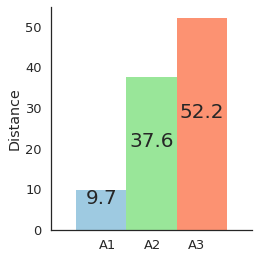

In [22]:
result = compute_prediction_distances("Prediction1(Police).csv","Police1")
bar_chart(list(result["Distance"].values),list(result["Task"].values), ytitle="Distance",fixed_ylim=False)

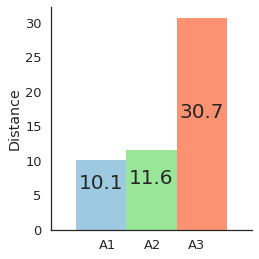

In [23]:
result = compute_prediction_distances("Prediction2(Police).csv","Police2")
bar_chart(list(result["Distance"].values),list(result["Task"].values), ytitle="Distance",fixed_ylim=False)

- cohen's kappa
- P, R 
- significance testing 

In [248]:
def compute_prediction_aggregate_stats(title,filename,gt_task_key):
    prediction = pd.read_csv(gdrive_path+filename)
    if "Police" in filename: 
        attributes = ["ticket","warn","arrest"]
        task_name = "Task1"
    else: 
        attributes = ["NO","YES"]
        task_name = "Task2"
    prediction = prediction.merge(user_task).drop("Note",axis=1)
    prediction_groupby=prediction.groupby(task_name)

    result = prediction_groupby.mean().reset_index()
    std_result = prediction_groupby.apply(lambda x: x.std()).reset_index()
    return result,std_result

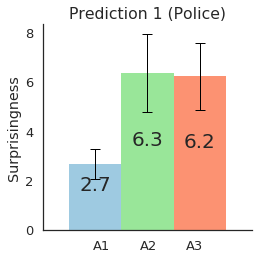

In [250]:
title="Prediction 1 (Police)"
filename = "Prediction1(Police).csv"
gt_task_key="Police1"
result,std_result = compute_prediction_aggregate_stats(title,filename,gt_task_key)
#Surprisingness Plot
bar_chart(list(result["Surprisingness"].values),list(result[task_name].values),list(std_result["Surprisingness"].values/2.),title=title, ytitle="Surprisingness",fixed_ylim=False)

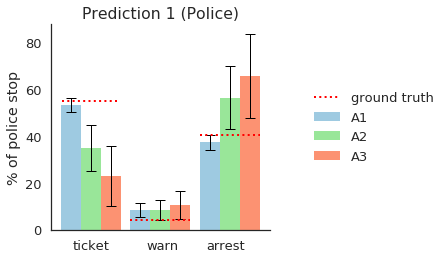

In [244]:
# def bar_chart(yVals, xAttrs, yErrs = [], xtitle="", ytitle="", title="", top_right_text="", N=1, width=0.1,autolabel_flag =True,fixed_ylim=True):

fixed_ylim=False

#######
xtitle=""
ytitle=""
top_right_text=""
N=1
width=0.1
autolabel_flag =True
#######
labels = result[task_name].values
fig, ax = plt.subplots()
col = 0
x0_lst =[]
for attr in attributes:
    x0= (col)*(ind + (i+0.5) * width + 0.1)
    x0_lst.append(x0[0])
    yVals = result[attr].values
    xAttrs = attributes
    yErrs = std_result[attr].values/2.

    ind = np.arange(N)  # the x locations for the groups
    if len(yVals)==2:
        colors = ["#fc9272","#9ecae1"]
        sns.set_palette(sns.color_palette(colors))
    else:
        colors = ["#9ecae1","#99e699","#fc9272"]
        sns.set_palette(sns.color_palette(colors))

    rects = []
    error_kw=dict(lw=1, capsize=5, capthick=1)
    for i in range(len(yVals)):
        if col==0:
            if yErrs==[]:
                rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width,label=labels[i])
            else:
                rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width, ecolor="black",yerr=yErrs[i],error_kw=error_kw,label=labels[i])
        else:
            if yErrs==[]:
                rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width)
            else:
                rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width, ecolor="black",yerr=yErrs[i],error_kw=error_kw)
        rects.append(rect)

    xtitle = xtitle.replace('"', '')
    ytitle = ytitle.replace('"', '')

    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    if title != "":
        title = title.replace('"','')
        title = title.replace("#", ",\n")
        if title[0] == ',':
            title = title[2:-2]
        if title.count(',') < 3:
            ax.set_title(title)
        else:
            ax.set_title(title)
    xmin = -0.05
    xmax = 0.25 + 0.1 * (len(yVals) - 2)
    xtickpos = [np.abs(xmin - xmax) / (len(yVals) + 1.5) * (i + 0.7) for i in range(len(yVals))]
    xtickpos=[0.15,0.51,0.83]
    ax.set_xticks(xtickpos)
    ax.set_xticklabels(xAttrs)

    if fixed_ylim: ax.set_ylim((0, 100))
    size = 0
    for rect in rects:
        size += 1
    sns.despine(top=True, right=True)
    col+=1
for col_i in range(len(attributes)):
    if col_i==0:
        ax.axhline(prediction_ground_truth[gt_task_key][col_i],xtickpos[col_i]-1*width,xtickpos[col_i]+1.5*width, linestyle=":",linewidth=2, color='r',label="ground truth")
    else:
        ax.axhline(prediction_ground_truth[gt_task_key][col_i],xtickpos[col_i]-1.5*width,xtickpos[col_i]+1.25*width, linestyle=":",linewidth=2, color='r')
plt.tight_layout()
plt.ylabel("% of police stop")
lgd = plt.legend(numpoints=1, loc="center right", bbox_to_anchor=(1.8, 0.5))

#plt.savefig("PR_obj{0}_{1}.pdf".format(objid,postprocess), bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()